# Dorefanet auf der Webcam

## 1. Import

In [1]:
import os, pickle, random
from datetime import datetime
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline
import IPython
import numpy as np
import cv2

import qnn
from qnn import Dorefanet
from qnn import utils

## 2. Start und Vorbereitung des Netzes

In [2]:
# Set classifier
classifier = Dorefanet()
classifier.init_accelerator()
net = classifier.load_network(json_layer="/usr/local/lib/python3.6/dist-packages/qnn/params/dorefanet-layers.json")

conv0_weights = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/dorefanet-conv0.npy', encoding="latin1").item()
fc_weights = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/dorefanet-fc-normalized.npy', encoding='latin1').item()

In [3]:
# Set classes
with open("imagenet-classes.pkl", 'rb') as f:
    classes = pickle.load(f)
    names = dict((k, classes[k][1].split(',')[0]) for k in classes.keys())
    synsets = dict((classes[k][0], classes[k][1].split(',')[0]) for k in classes.keys())

In [4]:
# Set weights
conv0_W = conv0_weights['conv0/W']
conv0_T = conv0_weights['conv0/T']
# FC Layer 0
fc0_W = fc_weights['fc0/Wn']
fc0_b = fc_weights['fc0/bn']
# FC Layer 1
fc1_W = fc_weights['fc1/Wn']
fc1_b = fc_weights['fc1/bn']
# FC Layer 2
fct_W = fc_weights['fct/W']

in_dim = net['conv0']['output'][1]
in_ch = net['conv0']['output'][0]
out_dim = net['merge4']['output_dim']
out_ch = net['merge4']['output_channels']

conv_output = classifier.get_accel_buffer(out_ch, out_dim)

## 3. Loop

KeyboardInterrupt: 

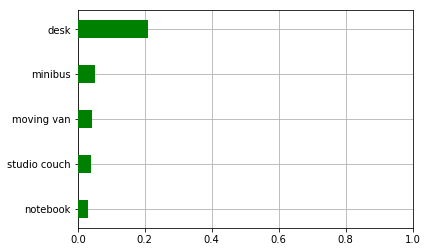

In [5]:
img_folder = './imagenet-samples/'

while (1):
    vc = cv2.VideoCapture(0)
    if vc.isOpened(): # try to get the first frame
        is_capturing, frame_in = vc.read()
        frame = cv2.cvtColor(frame_in, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
        cv2.imwrite('frame.jpg', frame_in)
        #webcam_preview = plt.imshow(frame)    
        #plt.savefig('frame.jpg')
        #plt.close()
    vc.release()
    
    img_file = 'frame.jpg'#os.path.join(img_folder, image_name)
    img, img_class = classifier.load_image(img_file)
    im = Image.open(img_file)
    # 1st convolutional layer execution, having as input the image and the trained parameters (weights)
    conv0 = utils.conv_layer(img, conv0_W, stride=4)
    # The result in then quantized to 2 bits representation for the subsequent HW offload
    conv0 = utils.threshold(conv0, conv0_T)

    conv_input = classifier.prepare_buffer(conv0)

    # Compute offloaded convolutional layers
    classifier.inference(conv_input, conv_output)
    fc_in = classifier.postprocess_buffer(conv_output)

    # Normalize results
    fc_input = fc_in / np.max(fc_in)
    fc0_out = utils.fully_connected(fc_input, fc0_W, fc0_b)
    fc0_out = utils.qrelu(fc0_out)
    fc0_out = utils.quantize(fc0_out, 2)
    fc1_out = utils.fully_connected(fc0_out, fc1_W, fc1_b)
    fc1_out = utils.qrelu(fc1_out)
    fct_b = np.zeros((fct_W.shape[1], ))
    fct_out = utils.fully_connected(fc1_out, fct_W, fct_b)
    # Softmax
    out = utils.softmax(fct_out)
    # Top-5 results
    topn =  utils.get_topn_indexes(out, 5)  
    x_pos = np.arange(len(topn))
    plt.barh(x_pos, out[topn], height=0.4, color='g', zorder=3)
    plt.yticks(x_pos, [names[k] for k in topn])
    plt.gca().invert_yaxis()
    plt.xlim([0,1])
    plt.grid(zorder=0)
    IPython.display.clear_output(1)
    display(im)
    plt.show()
    if img_class in synsets.keys():
        print("Image class: {:>5}\nPredictions:".format(synsets[img_class]))
        for k in topn: print("class:{0:>15}\tprobability:{1:>8.2%}".format(names[k].lower(), out[k]))
        if synsets[img_class] in (names[k] for k in topn):
            print("\nMatch!")
    else:    
        for k in topn: print("class:{0:>20}\tprobability:{1:>8.2%}".format(names[k].lower(), out[k]))

## 4. Deinitialisierung

In [6]:
classifier.deinit_accelerator()
from pynq import Xlnk

xlnk = Xlnk();
xlnk.xlnk_reset()